For the final project, I'll analyze the CoffeeKing dataset (Yelp Academic Dataset), to see if there's anything interesting we can dig out.  
Here's the discription:  
CoffeeKing is a new startup coffee company providing a unique and novel experience to their customers.  They want to appeal to a wide variety of clientele.  You will use Yelp reviews and user data to provide insights to CoffeeKing for things such as location selection and/or hours of operation (and other questions?)  
  
### First, import the packages we needed to do EDA.

In [8]:
# Packages for data process
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib
import matplotlib.pyplot as plt
import scipy
pd.set_option('display.max_colwidth',-1)

In [ ]:
# Packages for NLP
import ast
import spacy
# spacy.cli.download("en_core_web_sm")
spacy.load('en_core_web_sm')
from spacy.lang.en import English
import nltk
# nltk.download('wordnet')
from nltk import pos_tag
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
# nltk.download('stopwords')
from gensim import corpora
import pickle
import gensim
from pyLDAvis import gensim_models

In [ ]:
# import importlib
# importlib.reload(util)
from util import *

Check for data's basic information.

In [102]:
# Check for total size
json_path = 'C:/Users/user/Desktop/CoffeKing (Yelp Academic Dataset)/'

print('size of store: ', count_total_rows(json_path, 'yelp_academic_dataset_business.json', 100000))
print('size of review: ', count_total_rows(json_path, 'yelp_academic_dataset_review.json', 100000))
print('size of user: ', count_total_rows(json_path, 'yelp_academic_dataset_user.json', 100000))

size of store:  160585
size of review:  8635403
size of user:  2189457


In [152]:
# Find stores selling coffee
yelp_bs = pd.read_json(json_path + 'yelp_academic_dataset_business.json', lines=True)
yelp_bs['categories'] = yelp_bs['categories'].map(lambda x: to_lower_case(x))
yelp_bs = yelp_bs[yelp_bs['categories'].str.contains('coffee').map(lambda x: True if x is True else False)] # Find store category with "coffee"
coffee_id = list(yelp_bs['business_id'])

In [154]:
# Deal with review, append reviews of the coffee stores
coffee_review = []
with open(json_path + "yelp_academic_dataset_review.json", "r") as f:
    reader = pd.read_json(json_path + "yelp_academic_dataset_review.json", 
                        lines=True, chunksize=100000)
    for chunk in reader:
        chunk = chunk[chunk['business_id'].isin(coffee_id)]
        coffee_review.append(chunk)
f.close()

In [155]:
yelp_rv = pd.concat(coffee_review, ignore_index=True)
user_id = yelp_rv['user_id'].unique().tolist()

In [156]:
# Search for user information
user_info = []
with open(json_path + "yelp_academic_dataset_user.json", "r") as f:
    reader = pd.read_json(json_path + "yelp_academic_dataset_user.json", 
                        lines=True, chunksize=100000)
    for chunk in reader:
        chunk = chunk[chunk['user_id'].isin(user_id)]
        user_info.append(chunk)
f.close()

In [157]:
yelp_user = pd.concat(user_info, ignore_index=True)

In [158]:
# Drop columns we don't need
yelp_bs.drop(["address", "postal_code", "latitude", "longitude"], axis=1, inplace=True)
yelp_rv.drop(["review_id"], axis=1, inplace=True)
yelp_user.drop(["name", "friends"], axis=1, inplace=True)

In [159]:
# Change column names that may duplicated
yelp_bs.rename(columns={"stars":"store_stars", "review_count":"store_review_count"}, inplace=True)
yelp_rv.rename(columns={"stars":"rv_stars", "useful":"rv_useful", "funny":"rv_funny", "cool":"rv_cool"}, inplace=True)
yelp_user.rename(columns={"review_count":"user_review_count"}, inplace=True)

In [160]:
# Merge tables, base on review
yelp_coffee = pd.merge(pd.merge(yelp_rv, yelp_bs, on="business_id", how='left'), 
                        yelp_user, on="user_id", how='left')

In [162]:
# Save merged table
yelp_coffee.to_csv(json_path + 'yelp_coffee.csv')

In [161]:
# Brief descrive of our merged table
print('We have {} distinct coffee stores.'.format(yelp_coffee['business_id'].unique().shape[0]))
print('With {} reviews about those stores.'.format(yelp_coffee.shape[0]))
print('And {} distinct users comment on them.'.format(yelp_coffee['user_id'].unique().shape[0]))
print('Our merged table has {} rows and {} features.'.format(yelp_coffee.shape[0],yelp_coffee.shape[1]))

We have 7747 distinct coffee stores.
With 605303 reviews about those stores.
And 321890 distinct users comment on them.
Our merged table has 605303 rows and 36 features.


### Now we can start to find what's in our table.

In [10]:
json_path = 'C:/Users/user/Desktop/CoffeKing (Yelp Academic Dataset)/'
yelp_coffee = pd.read_csv(json_path + 'yelp_coffee_category.csv',index_col=0)
yelp_coffee

,user_id,business_id,rv_stars,rv_useful,rv_funny,rv_cool,text,date,name,city,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JHXQEayrDHOWGexs0dCviA,KXCXaF5qimmtKKqnPc_LQA,1,0,0,0,Great coffee and pastries. Baristas are excellent. All the other staff are sooooo lost and vacant.,2018-03-03 23:45:25,Thierry,Vancouver,...,2,0,0,0,2,11,2,2,0,1
1,LV1ME-ibA2h0IGyFUUWhaQ,H_RM2u1WWGU1HkKZrYq2Ow,5,0,0,0,Incredible donuts. Sometimes you have to go early to have the full selection but the donuts never disappoint.,2017-08-07 19:34:13,Blue Star Donuts,Portland,...,0,0,0,0,0,1,0,0,0,0
2,JuM-lH05m6Ln8OPUTg8p0g,H_RM2u1WWGU1HkKZrYq2Ow,5,0,0,0,"Dont bother going to voodoo, just come here instead. They have such unique flavors and everything is so fresh. Oh, and try their cold brew too!",2016-09-18 17:06:01,Blue Star Donuts,Portland,...,0,0,0,0,0,1,0,0,0,0
3,4cDqW9sWnZ57tsIEiElJWw,0nMbLN0B5I-2tNnQLSo86w,5,4,4,4,"""Even the mad Captain Ahab is touched by Starbuck's goodness...""\n Herman Melville \n\nThe drive-thru was jammed with vehicles when I pulled up, so I opted to park and go to the walk-up window. \n\nThe staff were super friendly! More then a few of them said hello to me while I ordered. Even though they were busy, they were all genuinely smiling. They look like they enjoy their job. Great teamwork! \nI think this is the friendliest Starbucks I've ever visited. \n\nThe building is architecturally pleasing to me so it catches my eye every time I've driven past it. I'm glad I stopped this time.\n\nIt's close to my freeway entrance so I'll be making this a regular stop from now on. If you're in the area, you should too!",2017-12-02 19:41:59,Starbucks,Portland,...,16,0,3,0,82,224,237,237,66,75
4,7mWnNVk2n99JxkvV3PW0nA,Un6u2cECyV4nZb_HGZ-uTA,4,1,0,1,"It's crazy how establishments on the west coast have so many more yelp reviews than places on the east coast. I find this extremely fascinating and I wish more people would be as passionate as the west coast has proven to me.\n\nIt was recommended that we go here for brunch...needless to say whomever told me this, is a genius.\n\nFresh brunch food, delicious infused vodka's, awesome buttermilk biscuits.\n\nI ordered the ""roll over"" two potato cakes that had a egg scramble with delicious sausage that wasn't gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy. Personally, I chose the mushroom rosemary gravy and I think that it was hands down the best gravy I had ever tried.\n\nI might has well licked the entire plate because it looked like it when I was finished. The flavors were just right and I was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking!\n\nLastly, make sure you order the biscuit too because it's heaven baked in the oven for your enjoyment.\n\nTake care & savor it up!",2011-02-13 16:38:09,Tin Shed Garden Cafe,Portland,...,4,1,0,3,12,28,28,28,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605298,im-MIiI-UFJsdrmIaxer2A,edlA6hSakvNxRZQFbuf-Iw,3,0,0,0,"I've always gone to sharetea wherever I go for boba, and this place is by far my least favorite. For one, they told me they only do 100% or 80% even though the menu says otherwise. Also asked for almond milk substitute, but they used soy milk instead.\n\nOn the brighter side, they do give you a lot of boba in the drinks, and the workers were friendly.",2021-01-25 23:04:35,Sharetea,Beaverton,...,0,0,0,0,0,0,0,0,0,0
605299,Cs5isLcwZgK-Cd1SA4TShw,p4sp8NYrFW7MmBajumBrtg,1,1,0,0,Every time I come to this dunkin they don't give me the correct coffee or forget stuff from my order. Drive the extra miles for a different dunkin,2020-06-30 14:21:53,Dunkin',Dunwoody,...,0,0,0,0,0,0,0,0,0,0
605300,_ailSgaI-3ztQxRnZtcluw,3uyvi_du7-s

In [11]:
yelp_coffee.columns

Index(['user_id', 'business_id', 'rv_stars', 'rv_useful', 'rv_funny',
       'rv_cool', 'text', 'date', 'name', 'city', 'state', 'store_stars',
       'store_review_count', 'is_open', 'attributes', 'categories', 'hours',
       'user_review_count', 'yelping_since', 'useful', 'funny', 'cool',
       'elite', 'fans', 'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'],
      dtype='object')

<AxesSubplot:>

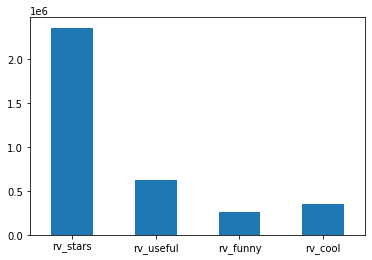

In [12]:
# Numbers of different types of reviews
yelp_coffee[['rv_stars', 'rv_useful', 'rv_funny', 'rv_cool']].sum().plot.bar(rot=0)

Looks like there's more "useful" review than the others.  
Since we got too many reviews and stores in our data, let's filter out with store_review_count.

(1411, 36)


<AxesSubplot:xlabel='store_review_count'>

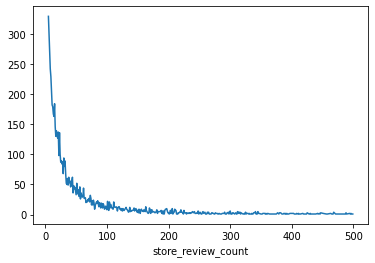

In [13]:
shop_filter = yelp_coffee.drop_duplicates('business_id').groupby('store_review_count')['business_id'].count()
print(yelp_coffee[yelp_coffee['store_review_count']>100].drop_duplicates('business_id').shape)
shop_filter[shop_filter.index<500].plot.line()

Looks like review_count 100 is a good point.  
And after filtering, we have 1411 stores remain.

In [14]:
yelp_coffee_filtered = yelp_coffee[yelp_coffee['store_review_count']>100]

In [15]:
yelp_coffee_filtered.columns

Index(['user_id', 'business_id', 'rv_stars', 'rv_useful', 'rv_funny',
       'rv_cool', 'text', 'date', 'name', 'city', 'state', 'store_stars',
       'store_review_count', 'is_open', 'attributes', 'categories', 'hours',
       'user_review_count', 'yelping_since', 'useful', 'funny', 'cool',
       'elite', 'fans', 'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'],
      dtype='object')

In [16]:
yelp_coffee_filtered[['rv_stars','text']]

,rv_stars,text
0,1,Great coffee and pastries. Baristas are excellent. All the other staff are sooooo lost and vacant.
1,5,Incredible donuts. Sometimes you have to go early to have the full selection but the donuts never disappoint.
2,5,"Dont bother going to voodoo, just come here instead. They have such unique flavors and everything is so fresh. Oh, and try their cold brew too!"
4,4,"It's crazy how establishments on the west coast have so many more yelp reviews than places on the east coast. I find this extremely fascinating and I wish more people would be as passionate as the west coast has proven to me.\n\nIt was recommended that we go here for brunch...needless to say whomever told me this, is a genius.\n\nFresh brunch food, delicious infused vodka's, awesome buttermilk biscuits.\n\nI ordered the ""roll over"" two potato cakes that had a egg scramble with delicious sausage that wasn't gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy. Personally, I chose the mushroom rosemary gravy and I think that it was hands down the best gravy I had ever tried.\n\nI might has well licked the entire plate because it looked like it when I was finished. The flavors were just right and I was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking!\n\nLastly, make sure you order the biscuit too because it's heaven baked in the oven for your enjoyment.\n\nTake care & savor it up!"
5,4,"5 stars for the location, it's absolutely wonderful. I ordered the shamrock bubble tea, which was one of the best I've ever had. I am subtracting a star for service however. It was the barista that was so put out by waiting on us and then the 10-15 minutes it took to make the bubble tea... That's a bit long for a drink."
...,...,...
605295,5,"Ever since I returned from Australia, I wondered why restaurants here didn't go above and beyond on food presentation the way that the Aussies did. Edible Flowers, gorgeous dishes, beautiful bright and colorful layers stacked high, etc. was just not a thing in Portland. There is something about it that makes the dining experience just a bit more pleasant, and as soon as I heard about Proud Mary, I felt those same nostalgic Australian vibes. Turns out, Proud Mary is from Melbourne, and everything made sense.\n\nI got to hear beautiful accents all around me, eat my Vegemite on toast, drink delicious coffee, sit in a gorgeous restaurant, and eat beautiful food. I got to escape for a bit, and I felt like I was back on the other side of the world. \n\nI'm still waiting for the edible floral and fruit stacked pancakes that I have yet to find in America, but I will wait. I know they'll come. As for what I did have, delicious. I am praying for more and more vegan items to show up on the menu, but I like the options we've been given thus far. \n\nGood on ya"
605296,4,"It's a super solid coffee shop. You could tell how good their coffee is just by the amount of people waiting in line at 9 in the morning, and there aren't any other places nearby that are worth stopping by either. The inside is very unique and gives a slightly ""rugged"" vibe (?). I ordered a chai latte, and I really liked it. It's on the milkier side, and even watered down, it's still good. My friend ordered an iced vanilla latte, and it's also on the creamier side. I preferred my chai latte. I love how they're handling COVID (only one customer inside at a time). They also have delicious pastries. I would definitely come back again!"
605297,5,"Chattahoochee Coffee Company you are really amazing, I had an incredible experience here yesterday. Outstanding menu items, welcoming staff, charming mood - what more could you ask for? Each and every single thing that we have purchased was very fresh and yummy. Staff ensured that every thing was fine. The service was good and I would definitely go back to Chattahoochee Coffee Co

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
parser = English()
# text tokenize
def tokenize(text):
    lda_tokens=[]
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [91]:
# Get pos
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    else:
        return None

def get_lemma(text):
    lemma_sent = []
    tagged_text = pos_tag(text)
    for word in tagged_text:
        wordnet_pos = get_wordnet_pos(word[1]) or wn.NOUN
        lemma_sent.append(WordNetLemmatizer().lemmatize(word[0], pos = wordnet_pos))
    return lemma_sent

en_stop = set(nltk.corpus.stopwords.words('english'))

In [93]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    # Only for text length >4
    tokens = [token for token in tokens if len(token)>4]
    # Lemmatize words
    tokens = get_lemma(tokens)
    tokens = [token for token in tokens if token not in en_stop]
    return tokens

In [94]:
yelp_coffee_filtered['text_token'] = yelp_coffee_filtered['text'].map(lambda text:prepare_text_for_lda(text))

C:\Users\user\AppData\Local\Temp/ipykernel_20792/3149793168.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_coffee_filtered['text_token'] = yelp_coffee_filtered['text'].map(lambda text:prepare_text_for_lda(text))


In [95]:
# Check how many reviews are not tokenized
print('Total reviews: ', yelp_coffee_filtered.shape[0])
print('Tokenized reviews: ', yelp_coffee_filtered[yelp_coffee_filtered['text_token'].str.len() != 0].shape[0])

Total reviews:  416113
Tokenized reviews:  416083


In [96]:
# Take a look at those not tokenized
yelp_coffee_filtered[yelp_coffee_filtered['text_token'].str.len() == 0][['text','text_token']]

,text,text_token
12488,Not the best but the best take out .... That was good!,[]
18464,.,[]
59748,Love the Taro milk tea so much!!!,[]
65820,i like bc it has cafe au lait.,[]
99787,。Ama！。,[]
115536,THE best Pho I've ever had. 'Nuff Said.,[]
140631,.,[]
212619,YES!!!,[]
215545,eh,[]
221481,best cafe au lait in town.enough said.,[]


In [97]:
# Take a look at those tokenized
yelp_coffee_filtered[['text','text_token']].head(10)

,text,text_token
0,Great coffee and pastries. Baristas are excellent. All the other staff are sooooo lost and vacant.,"[great, coffee, pastry, baristas, excellent, staff, sooooo, vacant]"
1,Incredible donuts. Sometimes you have to go early to have the full selection but the donuts never disappoint.,"[incredible, donut, sometimes, early, selection, donut, never, disappoint]"
2,"Dont bother going to voodoo, just come here instead. They have such unique flavors and everything is so fresh. Oh, and try their cold brew too!","[bother, go, voodoo, instead, unique, flavor, everything, fresh]"
4,"It's crazy how establishments on the west coast have so many more yelp reviews than places on the east coast. I find this extremely fascinating and I wish more people would be as passionate as the west coast has proven to me.\n\nIt was recommended that we go here for brunch...needless to say whomever told me this, is a genius.\n\nFresh brunch food, delicious infused vodka's, awesome buttermilk biscuits.\n\nI ordered the ""roll over"" two potato cakes that had a egg scramble with delicious sausage that wasn't gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy. Personally, I chose the mushroom rosemary gravy and I think that it was hands down the best gravy I had ever tried.\n\nI might has well licked the entire plate because it looked like it when I was finished. The flavors were just right and I was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking!\n\nLastly, make sure you order the biscuit too because it's heaven baked in the oven for your enjoyment.\n\nTake care & savor it up!","[crazy, establishment, coast, review, place, coast, extremely, fascinating, people, would, passionate, coast, proven, recommend, brunch, needless, whomever, genius, fresh, brunch, delicious, infuse, vodka, awesome, buttermilk, biscuit, order, potato, cake, scramble, delicious, sausage, gross, cover, grease, top, choice, bacon, gravy, mushroom, rosemary, gravy, personally, chose, mushroom, rosemary, gravy, think, hand, gravy, try, might, lick, entire, plate, look, finished, flavor, right, shock, greasiness, usual, breakfast, food, perfectly, prepare, dish, like, lastly, order, biscuit, heaven, bake, enjoyment, savor]"
5,"5 stars for the location, it's absolutely wonderful. I ordered the shamrock bubble tea, which was one of the best I've ever had. I am subtracting a star for service however. It was the barista that was so put out by waiting on us and then the 10-15 minutes it took to make the bubble tea... That's a bit long for a drink.","[star, location, absolutely, wonderful, order, shamrock, bubble, subtract, service, however, barista, wait, minute, bubble, drink]"
7,"Falafel wrap - falafel with greens, pickles, and hummus in a toasted wrap. I wonder why the reviews were so low. I entered without looking at yelp initially but then after checking in and seeing the amount of stars I kind of grew the assumption that it wasn't going to be good. But it was really good. This was probably the best falafel wrap I ever had. They pressed the wrap too so it has a nice crunch but still soft to chew. The falafels weren't bland and each bite tasted the same, which makes wraps great, since it's evenly disturbed. \n\nThey are far from cheap on the stuffing so eat up! The wait time wasn't long during their busy time and it's a good portion for a hungry person, so I suggest checking this place out.","[falafel, falafel, green, pickle, hummus, toast, wonder, review, enter, without, look, initially, check, see, amount, star, assumption, go, really, probably, falafel, press, crunch, still, falafels, bland, taste, make, wrap, great, since, evenly, disturb, cheap, stuff, portion, hungry, person, suggest, check, place]"
8,"If this isn't your first time at the specialty coffee rodeo and if you know you're way around a pour over, burr gr

In [98]:
# Create dictionary via gensim
dictionary = corpora.Dictionary(yelp_coffee_filtered['text_token'].to_list())
# Creating corpus
corpus = [dictionary.doc2bow(text) for text in yelp_coffee_filtered['text_token'].to_list()]

In [99]:
# Save the dictionary
pickle.dump(corpus,open('corpus.pkl','wb'))
dictionary.save('dictionary.gensim')

In [100]:
# Using LDA find 10 topics
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word = dictionary, passes=15)
# Save the model
ldamodel.save('10topics/yelp_topics.gensim')

In [101]:
# Top 5 words in each topic
topics = ldamodel.print_topics(num_words = 5)
# Take a look at each topic
for topic in topics:
    print(topic)

(0, '0.026*"chicken" + 0.024*"toast" + 0.022*"cheese" + 0.022*"breakfast" + 0.019*"sauce"')
(1, '0.066*"donut" + 0.025*"doughnut" + 0.018*"flavor" + 0.014*"blueberry" + 0.012*"cinnamon"')
(2, '0.010*"store" + 0.010*"business" + 0.010*"customer" + 0.010*"people" + 0.009*"thing"')
(3, '0.038*"seat" + 0.035*"table" + 0.031*"park" + 0.024*"bagel" + 0.023*"inside"')
(4, '0.026*"place" + 0.020*"drink" + 0.017*"taste" + 0.016*"really" + 0.014*"flavor"')
(5, '0.048*"cream" + 0.037*"chocolate" + 0.025*"flavor" + 0.023*"sweet" + 0.021*"pastry"')
(6, '0.041*"order" + 0.019*"service" + 0.018*"would" + 0.016*"place" + 0.013*"minute"')
(7, '0.119*"coffee" + 0.030*"place" + 0.022*"latte" + 0.018*"drink" + 0.016*"great"')
(8, '0.066*"great" + 0.056*"place" + 0.034*"friendly" + 0.033*"service" + 0.030*"staff"')
(9, '0.132*"sandwich" + 0.034*"breakfast" + 0.032*"bread" + 0.031*"vegan" + 0.024*"lunch"')


In [102]:
# Visualize the result
lda_display = gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics = False)
pyLDAvis.display(lda_display)

C:\Users\user\Anaconda3\envs\py3.9\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [103]:
# Let's get the most possible topic of each review
from operator import itemgetter
yelp_coffee_filtered['topic_10'] = yelp_coffee_filtered['text_token'].map(
    lambda text:max(ldamodel.get_document_topics(dictionary.doc2bow(text)), key = itemgetter(1))[0])

C:\Users\user\AppData\Local\Temp/ipykernel_20792/2673216804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_coffee_filtered['topic_10'] = yelp_coffee_filtered['text_token'].map(


In [107]:
# Let's see the relationship between topics and stars
star_topic_count = yelp_coffee_filtered.groupby(['rv_stars','topic_10'])['text_token'].count()

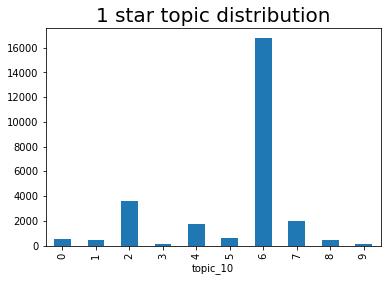

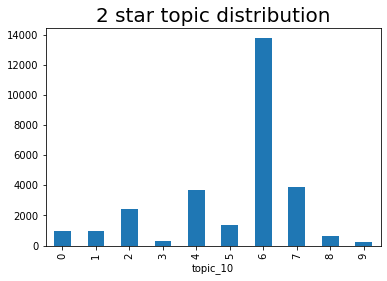

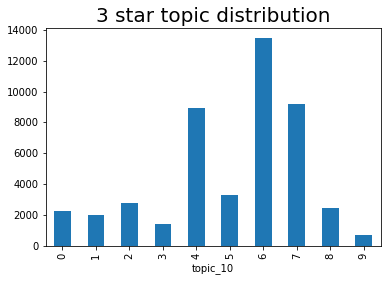

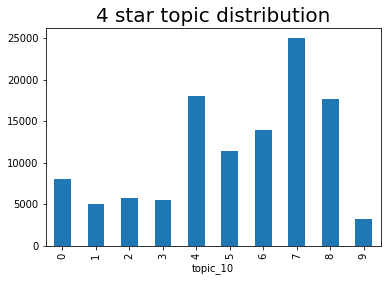

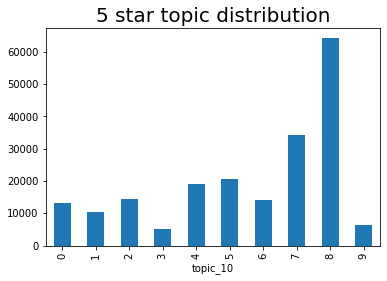

In [141]:
# Visualize the result
for star in list(np.sort(yelp_coffee_filtered['rv_stars'].unique())):
    plt.figure()
    star_topic_count.loc[star,].plot.bar()
    plt.title('{} star topic distribution'.format(star), fontsize=20)
    plt.show()

We can see that the low star reviews (<=3☆) mainly focus on topic 6  
And topic 4, 7 and 8 appear more in high star reviews (>=4☆)  
Now, we can go back to previous cell to check what are these topics.

Topic 6 got words like order, service, minute, wait, ask, arrive in it, so we can guess that it is about issue of waiting meals to be served.    
Topic 4 got words like bubble, matcha, drink, green, curry in it, so we can guess that it is about drinks other than coffee, or maybe some asian style of the store.  
Topic 7 got words like coffee, latte, espresso in it, so we can guess that it is about coffee's quality.  
We are hard to find what's about topic 8, since it gots words like friendly, helpful, great in it, but it does appear words like hookah, pricing, mask, covid19 in it, so maybe it is about constraint of the store? Not sure about it.  


Therefore we suggest that:  
1. The new store should watch out for the delivery speed of meals to avoid bad reviews.  
2. The new store can also sell drinks like bubble tea or matcha, since people give good review for that.  
3. The new store should still focus on the quality of coffee, since people do care and leave reviews about it.


In [142]:
# Let's try out more topics, this can make each topic more precise
# Using LDA find 30 topics
NUM_TOPICS = 30
ldamodel_30 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word = dictionary, passes=15)
# Save the model
ldamodel_30.save('30topics/yelp_topics_30.gensim')

In [143]:
# Top 5 words in each topic
topics_30 = ldamodel_30.print_topics(num_words = 5)
# Take a look at each topic
for topic in topics_30:
    print(topic)

(0, '0.293*"cream" + 0.174*"flavor" + 0.024*"coconut" + 0.021*"creamy" + 0.020*"taste"')
(15, '0.266*"sandwich" + 0.083*"salad" + 0.072*"lunch" + 0.067*"bread" + 0.042*"cheese"')
(16, '0.112*"staff" + 0.095*"friendly" + 0.088*"always" + 0.056*"place" + 0.052*"great"')
(29, '0.195*"chocolate" + 0.039*"whole" + 0.038*"sample" + 0.038*"white" + 0.033*"cheesecake"')
(23, '0.118*"cupcake" + 0.099*"good" + 0.082*"bake" + 0.047*"cookie" + 0.039*"cooky"')
(25, '0.089*"chicken" + 0.059*"sauce" + 0.043*"pizza" + 0.040*"fry" + 0.025*"restaurant"')
(19, '0.100*"breakfast" + 0.047*"toast" + 0.040*"brunch" + 0.032*"bacon" + 0.032*"biscuit"')
(7, '0.211*"donut" + 0.038*"apple" + 0.035*"bacon" + 0.035*"donuts" + 0.031*"fritter"')
(17, '0.165*"great" + 0.138*"service" + 0.045*"excellent" + 0.040*"price" + 0.039*"place"')
(22, '0.052*"crepe" + 0.052*"store" + 0.042*"portland" + 0.017*"selection" + 0.015*"visit"')
(2, '0.276*"option" + 0.160*"vegan" + 0.059*"gluten" + 0.038*"beer" + 0.035*"grit"')
(5, '0

In [144]:
# Visualize the result
lda_display = gensim_models.prepare(ldamodel_30, corpus, dictionary, sort_topics = False)
pyLDAvis.display(lda_display)

C:\Users\user\Anaconda3\envs\py3.9\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [151]:
# Let's get the most possible topic of each review
from operator import itemgetter
yelp_coffee_filtered['topic_30'] = yelp_coffee_filtered['text_token'].map(
    lambda text:max(ldamodel_30.get_document_topics(dictionary.doc2bow(text)), key = itemgetter(1))[0])

C:\Users\user\AppData\Local\Temp/ipykernel_20792/3902409260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_coffee_filtered['topic_30'] = yelp_coffee_filtered['text_token'].map(


In [152]:
# Save the result
yelp_coffee_filtered.to_csv('yelp_coffee_topic.csv')

In [154]:
# Let's see the relationship between topics and stars
star_topic30_count = yelp_coffee_filtered.groupby(['rv_stars','topic_30'])['text_token'].count()

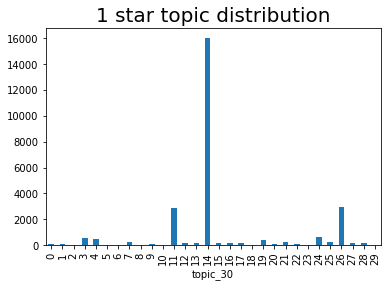

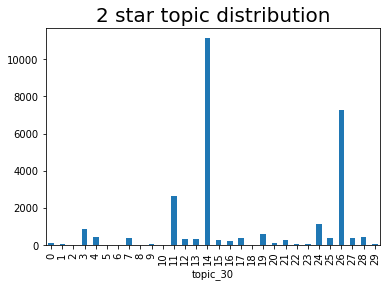

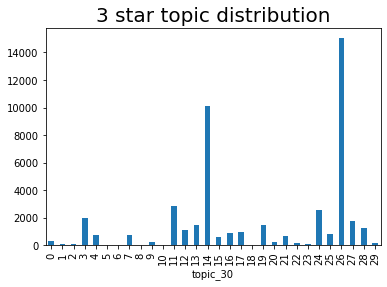

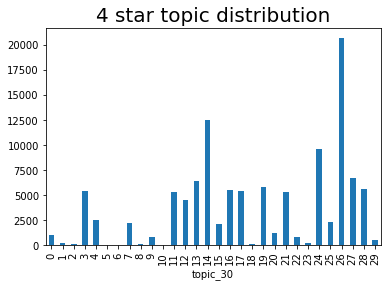

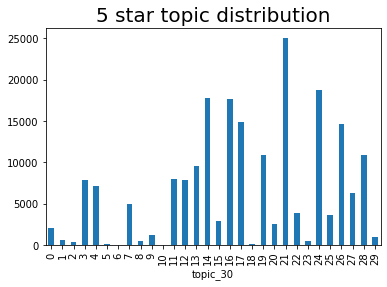

In [155]:
# Visualize the result
for star in list(np.sort(yelp_coffee_filtered['rv_stars'].unique())):
    plt.figure()
    star_topic30_count.loc[star,].plot.bar()
    plt.title('{} star topic distribution'.format(star), fontsize=20)
    plt.show()

In [ ]:
json_path = 'C:/Users/user/Desktop/CoffeKing (Yelp Academic Dataset)/'
yelp_coffee_filtered = pd.read_csv(json_path + '/yelp_coffee_topic.csv', index_col=0)

In [ ]:
# Looking trend of yelp reviews by year/time


In [ ]:
# Looking people that frequently post about coffee shops on yelp
